In [1]:
import json
import sympy
import numpy
import matplotlib.pyplot as plt

from mira.metamodel import *
from mira.modeling import Model
from mira.modeling.ode import OdeModel, simulate_ode_model
from mira.modeling.amr.regnet import template_model_to_regnet_json
from mira.modeling.amr.petrinet import template_model_to_petrinet_json

## Define states for the model


In [2]:
susceptible = Concept(name="s", identifiers={"ido": "0000514"})
infected = Concept(name="i", identifiers={"ido": "0000511"})
recovered_broadly = Concept(name="b", identifiers={"ido": "0000592"},
                            context={"status": "broad"})
recovered_fully = Concept(name="r", identifiers={"ido": "0000592"},
                          context={"status": "full"})

## Define templates

In [3]:
templates = [
    ControlledConversion(
        subject=susceptible, outcome=infected, controller=infected
    ).with_mass_action_rate_law("beta"),
    NaturalConversion(
        subject=infected, outcome=recovered_broadly
    ).with_mass_action_rate_law("gamma"),
    NaturalConversion(
        subject=recovered_broadly, outcome=recovered_fully
    ).with_mass_action_rate_law("eta"),
]

## Define Parameters and Initials

In [4]:
one_over_day = Unit(expression=1/sympy.Symbol("day"))
parameters = {
    "beta": Parameter(name="beta", value=0.357, units=one_over_day),
    "gamma": Parameter(name="gamma", value=0.143, units=one_over_day),
    "eta": Parameter(name="eta", value=0.429, units=one_over_day),
}

In [5]:
initials = {
    "s0": Initial(concept=susceptible, expression=0.999),
    "i0": Initial(concept=infected, expression=0.001),
    "b0": Initial(concept=recovered_broadly, expression=0.0),
    "r0": Initial(concept=recovered_fully, expression=0.0),
}

## Create the template model

In [6]:
tm = TemplateModel(
    templates=templates, parameters=parameters, initials=initials
)

## Prepare the model for simulation


In [7]:
om = OdeModel(Model(tm), initialized=True)
om.kinetics

Matrix([
[                 -p[0, 0]*y[0, 0]*y[1, 0]],
[p[0, 0]*y[0, 0]*y[1, 0] - p[1, 0]*y[1, 0]],
[        p[1, 0]*y[1, 0] - p[2, 0]*y[2, 0]],
[                          p[2, 0]*y[2, 0]]])

In [8]:
ts = numpy.linspace(0, 100, 100)
res = simulate_ode_model(om, times=ts)

Text(0, 0.5, 'Percent of Population')

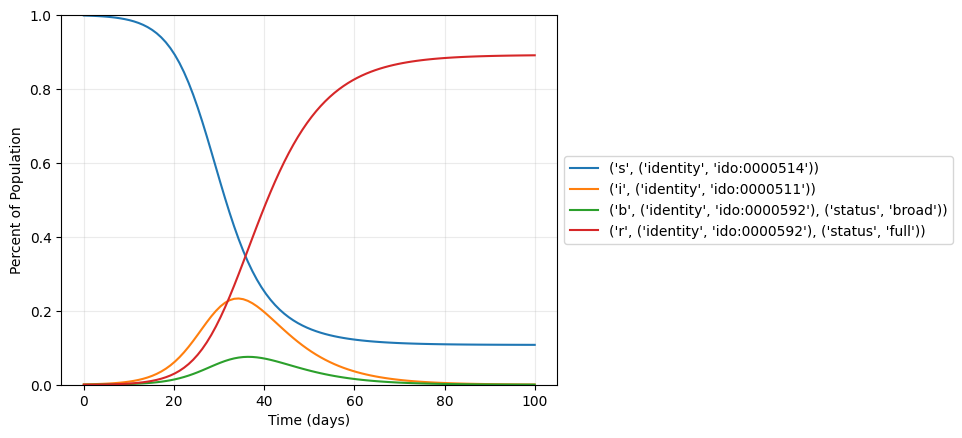

In [9]:
plt.plot(ts, res, label=om.vmap.keys())
plt.grid(alpha=0.25)
plt.ylim([0, 1])
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel("Time (days)")
plt.ylabel("Percent of Population")

## Export the model into a petrinet framework

In [10]:
with open(f"scenario1_model_b_petrinet.json", "w") as fh:
    json.dump(template_model_to_petrinet_json(tm), fh, indent=1)